# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = '../../DataSets/Traffic-Signs/train.p'
validation_file= '../../DataSets/Traffic-Signs/valid.p'
testing_file =  '../../DataSets/Traffic-Signs/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
train_x, train_y = train['features'], train['labels']
val_x, val_y = valid['features'], valid['labels']
test_x, test_y = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
n_train = len(train_x)
n_validation = len(val_x)
n_test = len(test)
image_shape = train_x[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(train_y))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 4
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

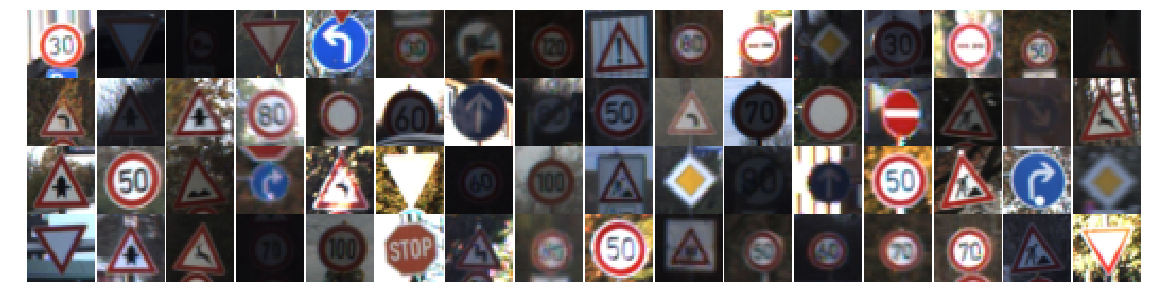

In [5]:
sample_i = np.random.choice(n_train, 64)
samples = train_x[sample_i]

n = len(samples)

plt.figure(figsize=(20,5))
for i in range(n):
    plt.subplot(4,16,i+1)
    plt.imshow(samples[i])
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)

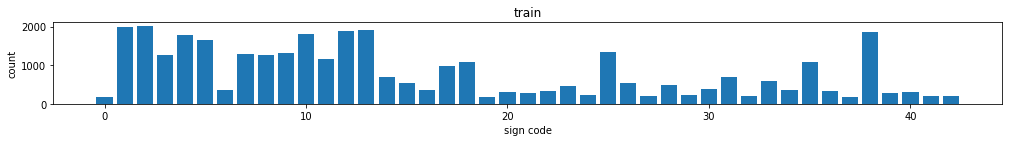

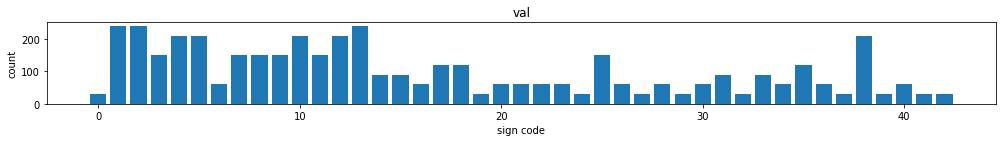

In [6]:
def hist_classes(labels, name=''):
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(17,1.5))
    plt.bar(unique, counts)
    plt.title(name)
    plt.xlabel('sign code')
    plt.ylabel('count')
    plt.show()
hist_classes(train_y, 'train')
hist_classes(val_y, 'val')

----

## Step 2: Design and Test a Model Architecture

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

[published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)

In [7]:
import tensorflow as tf

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [8]:
import cv2
from scipy import ndimage

set_mean  = np.mean(train_x)
set_sigma = np.std(train_x)

def normalize(Xs):
    #normalize by training data mean and sigma
    Xs = (Xs - set_mean)/set_sigma
    return Xs

def random_rotate(images, degrees=45):
    n = len(images)
    for i in range(n):
        d = np.random.uniform(-degrees,degrees)
        images[i] = ndimage.rotate(images[i], d, reshape=False)
    return images

def pre_process(Xs):
    Xs = normalize(Xs)
    Xs = random_rotate(Xs, degrees=45)
    
    return Xs

In [ ]:

samples = train_x[[102,0]]



### Model Architecture

In [9]:
#helper functions
sigmoid = tf.nn.sigmoid
relu = tf.nn.relu
elu = tf.nn.elu

def bias(size, zero=False):
    if zero:
        return tf.Variable(tf.zeros([size], dtype=tf.float32))
    else:
        return tf.Variable(tf.random_normal([size], stddev=0.1))
    
def conv(tensor, kernel_dims):
    ksize, n_in, n_out = kernel_dims
    kernels = tf.Variable(tf.random_normal([ksize, ksize, n_in, n_out],  stddev=0.1))
    loss = tf.nn.l2_loss(kernels)
    tf.add_to_collection('losses', loss)
    return tf.nn.conv2d(tensor,kernels, strides=[1, 1, 1, 1], padding='SAME') + bias(n_out)
def dense(tensor, in_size, out_size):
    weights = tf.Variable(tf.random_normal(shape=(in_size, out_size), mean=0, stddev=0.1))
    loss = tf.nn.l2_loss(weights)
    tf.add_to_collection('losses', loss)
    return tf.matmul(tensor, weights) + bias(out_size)

def max_pool(tensor, ksize):
    return tf.nn.max_pool(tensor, ksize=[1,ksize,ksize,1], strides=[1,2,2,1], padding='SAME')

def flatten(tensor):
    dim = tensor.shape.as_list()
    size = np.product(dim[1:])
    print(size)
    flat = tf.reshape(tensor, [-1, size])
    return flat, size

In [10]:
#Model specs
ksize = 5
n1 = 64
n2 = 64
n3 = 384
n4 = 192

In [11]:
#Model
x = tf.placeholder(tf.float32, [None, *image_shape],'X')
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

conv1 = elu(conv(x,[ksize,3,n1]))
conv1 = max_pool(conv1,ksize=3)
conv2 = elu(conv(conv1,[ksize,n1,n2]))
conv2 = max_pool(conv2, ksize=3)
flat, size = flatten(conv2)
dense1 = elu(dense(flat, size, n3))
dense2 = elu(dense(dense1, n3, n4))
logits = dense(dense2, n4, n_classes)

4096


In [12]:
#loss function
rate = 0.001

l2_loss = tf.reduce_sum(tf.get_collection('losses'))


cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy) + 0.0002*l2_loss
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
train_step = optimizer.minimize(loss_operation)

In [13]:
#Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

init = tf.global_variables_initializer()

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [14]:
sess = tf.InteractiveSession()

In [15]:
#creates batches "on the fly so as not to keep them in memory
def batches(X,y,batch_size=128):
    assert len(X) == len(y)
    n = len(X)
    p = np.random.permutation(n)
    
    num_batches = n // batch_size
    for i in range(num_batches):
        start = i*batch_size
        end = start+batch_size
        yield X[p[start:end]], y[p[start:end]]

    left_over = n % batch_size
    yield X[p[-left_over:]], y[p[-left_over:]]

In [16]:
#run epoch
def run_epoch(xs, ys, train=True, batch_size=128, augment=True):
    avg_loss = 0.
    avg_acc = 0.
    for batch_xs, batch_ys in batches(xs, ys, batch_size=batch_size):
        if augment:
            batch_xs = pre_process(batch_xs)
        else:
            batch_xs = normalize(batch_xs)
        feed_dict = {x: batch_xs, y: batch_ys}
        if train:
            opt, loss, acc = sess.run((train_step,loss_operation,accuracy_operation),
                                     feed_dict=feed_dict)
        else:
            loss, acc = sess.run((loss_operation, accuracy_operation),
                                feed_dict=feed_dict)
        n = len(xs)
        n_batch = len(batch_xs)
        avg_loss += loss / n * n_batch
        avg_acc += acc / n * n_batch
    return avg_loss, avg_acc

EPOCH: 0001, LOSS: 4.29769, ACC: 0.61499, VAL_LOSS: 3.02011, VAL_ACC: 0.69637, l2: 8606.46875
EPOCH: 0011, LOSS: 1.00900, ACC: 0.99270, VAL_LOSS: 1.60107, VAL_ACC: 0.88141, l2: 4714.10400
EPOCH: 0021, LOSS: 0.43660, ACC: 0.98445, VAL_LOSS: 0.99470, VAL_ACC: 0.90590, l2: 1873.42285
EPOCH: 0031, LOSS: 0.12201, ACC: 1.00000, VAL_LOSS: 0.23331, VAL_ACC: 0.96984, l2: 554.27460
EPOCH: 0041, LOSS: 0.06269, ACC: 1.00000, VAL_LOSS: 0.19720, VAL_ACC: 0.96599, l2: 287.35516
EPOCH: 0051, LOSS: 0.05534, ACC: 1.00000, VAL_LOSS: 0.24572, VAL_ACC: 0.96939, l2: 253.09497
EPOCH: 0061, LOSS: 0.04210, ACC: 0.99997, VAL_LOSS: 0.16435, VAL_ACC: 0.97347, l2: 193.29166
EPOCH: 0071, LOSS: 0.03571, ACC: 0.99997, VAL_LOSS: 0.27501, VAL_ACC: 0.94717, l2: 166.37129
EPOCH: 0081, LOSS: 0.04248, ACC: 1.00000, VAL_LOSS: 0.21880, VAL_ACC: 0.96576, l2: 198.12558
EPOCH: 0091, LOSS: 0.03603, ACC: 1.00000, VAL_LOSS: 0.20660, VAL_ACC: 0.97324, l2: 168.00186
EPOCH: 0101, LOSS: 0.07375, ACC: 0.99549, VAL_LOSS: 0.34247, VAL_AC

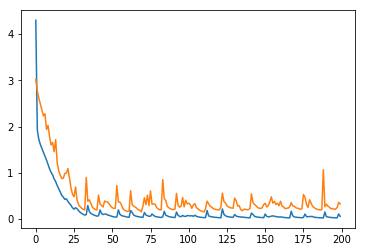

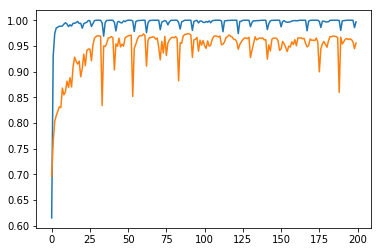

In [17]:
%%time
training_epochs = 200
display_step = 10

sess.run(init)
val_losses = []
losses = []
val_accs = []
accs = []
for epoch in range(training_epochs):
    train_loss, train_acc = run_epoch(train_x, train_y, augment=False, batch_size=128)
    val_loss, val_acc = run_epoch(val_x, val_y, train=False, augment=False, batch_size=128)
    
    val_losses.append(val_loss)
    losses.append(train_loss)
    val_accs.append(val_acc)
    accs.append(train_acc)
    
    l2 = sess.run(l2_loss)
    
    #Display every 'display_step' steps
    if epoch % display_step == 0:
        print ("EPOCH: %04d, LOSS: %.5f, ACC: %.5f, VAL_LOSS: %.5f, VAL_ACC: %.5f, l2: %.5f" % 
                   (epoch+1, train_loss, train_acc, val_loss, val_acc, l2))
if epoch % display_step == 0:
    print ("EPOCH: %04d, LOSS: %.5f, ACC: %.5f, VAL_LOSS: %.5f, VAL_ACC: %.5f" % 
                (epoch+1, train_loss, train_acc, val_loss, val_acc))

plt.plot(losses)
plt.plot(val_losses)
plt.figure()
plt.plot(accs)
_ = plt.plot(val_accs)

In [19]:
max(val_accs)

0.97414965962066125

In [ ]:
C = 0.001    -> 0.94
C = 0.0004   -> 0.97
C = 0.0003   -> 0.97
C = 0.0002   -> 0.98
C = 0.0001   -> 0.968
C = 0.000075 -> 0.972
C = 0.00005  -> 0.965
C = 0.00001  -> 0.92

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")